In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import re
import string
import matplotlib.pyplot as plt
#import matplotlib_venn as venn
import seaborn as sns


from tqdm import tqdm
import spacy
import random
from spacy.util import compounding
from spacy.util import minibatch
from collections import defaultdict
from collections import  Counter


# sklearn 
from sklearn import preprocessing
from sklearn import model_selection
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

#nltk
from nltk.corpus import stopwords
from nltk.util import ngrams
stop=set(stopwords.words('english'))
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image

#Avoid warning messages
import warnings
warnings.filterwarnings("ignore")

#plotly libraries
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
from plotly import tools
from plotly.subplots import make_subplots
import cufflinks
cufflinks.go_offline()
cufflinks.set_config_file(world_readable=True, theme='pearl')





In [2]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\priya\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
import os
cwd = os.getcwd()
cwd

'C:\\Users\\priya\\Documents\\Predictive Analytics\\Project'

In [4]:
#importing the text dataset in the form of dataframes
tweet_train = pd.read_csv("train.csv")
tweet_test = pd.read_csv("test.csv")
tweet_submission = pd.read_csv("sample_submission.csv")


In [5]:
#determining the shape of the data

print("Shape of Training Set:",tweet_train.shape)
print("Shape of Test Set:",tweet_test.shape)

Shape of Training Set: (27481, 4)
Shape of Test Set: (3534, 3)


In [6]:
#extracting information about training data
tweet_train.dropna(inplace=True)
tweet_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27480 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27480 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27480 non-null  object
dtypes: object(4)
memory usage: 1.0+ MB


In [7]:
#extracting information about test data

tweet_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3534 entries, 0 to 3533
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   textID     3534 non-null   object
 1   text       3534 non-null   object
 2   sentiment  3534 non-null   object
dtypes: object(3)
memory usage: 83.0+ KB


In [8]:
tweet_train.dropna(inplace=True)
tweet_train.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [9]:
tweet_test.head()

,textID,text,sentiment
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative
3,01082688c6,happy bday!,positive
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive


In [10]:
tweet_train.describe()

,textID,text,selected_text,sentiment
count,27480,27480,27480,27480
unique,27480,27480,22463,3
top,ee7ec11615,AGAIN AGAIN.,good,neutral
freq,1,1,199,11117


In [11]:
tweet_test.describe()

,textID,text,sentiment
count,3534,3534,3534
unique,3534,3534,3
top,6634c62acf,Yo Thomas! thanks for the follow Social Medi...,neutral
freq,1,1,1430


In [12]:
#Looking at the distrubution of the dataset

dist_train = tweet_train.groupby('sentiment').count()['text'].reset_index().sort_values(by='text',ascending=False)
dist_train.style.background_gradient(cmap='Blues')

,sentiment,text
1,neutral,11117
2,positive,8582
0,negative,7781


Text(0.5, 1.0, 'Count of Test class labels')

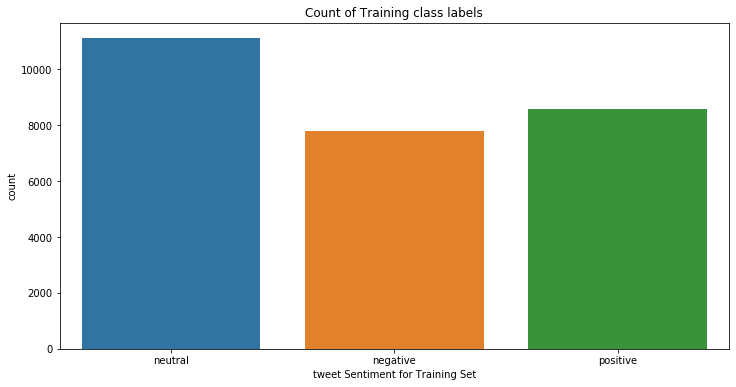

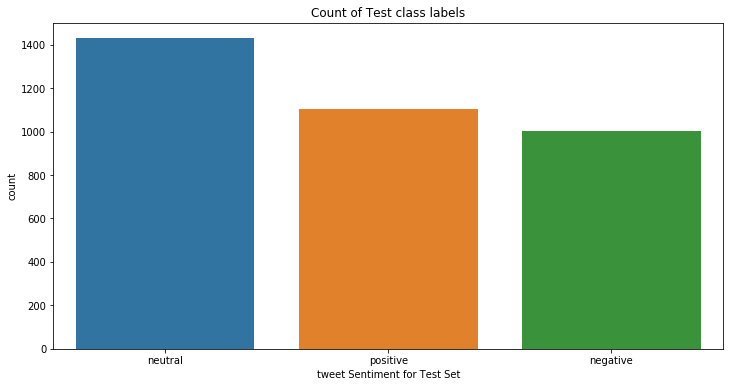

In [13]:
plt.figure(figsize=(12,6))
sns.countplot(x='sentiment',data=tweet_train)
plt.xlabel('tweet Sentiment for Training Set')
plt.title('Count of Training class labels')

plt.figure(figsize=(12,6))
sns.countplot(x='sentiment',data=tweet_test)
plt.xlabel('tweet Sentiment for Test Set')
plt.title('Count of Test class labels')


EDA on Selected text

We will undergo some basic text prepocessing and EDA on our target field- Selected Text.This is to understand how this feature is distributed in train data.

Find URLs
Punctuations
Length of tweets
Average of tweets
Most words

Why to consider URL?¶
URLs makes no sense for extreme sentiments.There are chances that they stay on neutral side.Lets check how they are spread in selected text

In [14]:
#converting text in sentiment to lower
tweet_train['target']=tweet_train['selected_text'].str.lower()


#finding the URL in sentiment
def find_URL(string): 
    url = re.findall('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', string)
    return "".join(url) 
tweet_train['target_url']=tweet_train['target'].apply(lambda x: find_URL(x))
df=pd.DataFrame(tweet_train.loc[tweet_train['target_url']!=""]['sentiment'].value_counts()).reset_index()
df.rename(columns={"index": "sentiment", "sentiment": "url_count"})

,sentiment,url_count
0,neutral,345
1,positive,3
2,negative,3


Observation:

As expected,our target variables that has urls are neutral tweets.Only few urls are found in positive and negative.
Our model would easily judge that if the text has URL it will be along neutral side.

Punctuations - Selected Text

Can punctutations/symbols play a part in modelling?
Since we are analysing sentimental tweets,people describe their emotions in symbols.Say symbols like continuous stars ( * ) is considered to be extreme emotions(happy,angry,delight etc).Other symbols like (# - tagging) or (@ - mention) are also used very often in tweets.

Lets analyse all of them including other punctuations

In [15]:
# Function to find punctuation in sentiment
def find_punctuation(text):
    line = re.findall(r'[!"\$%&\'()*+,\-.\/:;=#@?\[\\\]^_`{|}~]*', text)
    string="".join(line)
    return list(string)

# New Features with punctuation and punctuation length
tweet_train['target_punct']=tweet_train['target'].apply(lambda x:find_punctuation(x))
tweet_train['target_punct_len']=tweet_train['target'].apply(lambda x:len(find_punctuation(x)))

In [16]:
p_df=pd.DataFrame(tweet_train,columns=['target_punct','sentiment'])
p_df=p_df[p_df['target_punct'].map(lambda d: len(d)) > 0]
p_df=p_df.explode('target_punct')

positiveDf=pd.DataFrame(p_df.loc[p_df['sentiment']=="positive"]['target_punct'].value_counts()).reset_index().rename(columns={'index': 'punctuation','target_punct':'pos_punct'})
negativeDf=pd.DataFrame(p_df.loc[p_df['sentiment']=="negative"]['target_punct'].value_counts()).reset_index().rename(columns={'index': 'punctuation','target_punct':'neg_punct'})
neutralDf=pd.DataFrame(p_df.loc[p_df['sentiment']=="neutral"]['target_punct'].value_counts()).reset_index().rename(columns={'index': 'punctuation','target_punct':'neut_punct'})

In [17]:
fig = make_subplots(rows=1, cols=3)

fig.append_trace(go.Bar(x=positiveDf.punctuation[:10],y=positiveDf.pos_punct[:10],name='Positive',marker_color='green'), row=1, col=1)
fig.append_trace(go.Bar(x=negativeDf.punctuation[:10],y=negativeDf.neg_punct[:10],name='Negative',marker_color='red'), row=1, col=2)
fig.append_trace(go.Bar(x=neutralDf.punctuation[:10],y=neutralDf.neut_punct[:10],name='Neutral',marker_color='blue'), row=1, col=3)

fig.update_xaxes(showline=True, linewidth=2, linecolor='black', mirror=True)
fig.update_yaxes(showline=True, linewidth=2, linecolor='black', mirror=True)
fig.update_layout(title_text="Selected Text -Punctuations in different sentiments",title_x=0.5)
fig.show()

Impact of * in the sentiment

In [18]:
#function to determine '*' symbol
def find_starSymbol(text):
   # if len(text.split())<1:
    line=re.findall(r'[*]{2,5}',text)
    return len(line)

tweet_train['star']=tweet_train['target'].apply(lambda x:find_starSymbol(x))
tweet_train.loc[tweet_train['star']!=0]['sentiment'].value_counts().to_frame()

,sentiment
negative,317
neutral,248
positive,50


Eventhough negative shows high counts.Still it describes about neutral tweets dependency.Let us analyse the tweet with only ( * ) in tweet.

In [19]:
#function to determine only * symbols
def find_starSymbol_only(text):
    if len(text.split())==1:
        line=re.findall(r'[*]{2,5}',text)
        return len(line)
    else:
        return 0
    
    
#get column values that has only * in its tweet
tweet_train['only_star']=tweet_train['target'].apply(lambda x:find_starSymbol_only(x))
tweet_train.loc[tweet_train['only_star']==1]['sentiment'].value_counts()    

negative    96
Name: sentiment, dtype: int64

Impact of ! in the tweet

In [20]:
#function to determine ! in the tweet
def find_exclamatorySymbol(text):
   # if len(text.split())<1:
    line=re.findall(r'[!]',text)
    return len(line)

tweet_train['exclaim']=tweet_train['target'].apply(lambda x:find_exclamatorySymbol(x))
tweet_train.loc[tweet_train['exclaim']!=0]['sentiment'].value_counts().to_frame()

,sentiment
neutral,2636
positive,1512
negative,820


Observation:

All sentiment tweets have full stop and quotes on top of list which is expected.
Tweets with ( * ) only has negative sentiments
( # ) and ( @ ) are no where in top lists.

Length - Selected Text

In this section we will analyse more on words of selected_text. Before extracting length of selected_text words,let us remove urls and punctuation

Note: We need to keep in mind that while modelling we cant strip them.They play part in jaccard score.Now we will do this check the distribution of words only.

In [21]:
#function to remove URL

def remove_URL(string): 
    text = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'," ",string)
    return " ".join(text.split())


#function to remove punctuation
def remove_punctuation(text):
    line = re.sub(r'[!"\$%&\'()*+,\-.\/:;=#@?\[\\\]^_`{|}~]+'," ",text)
    return " ".join(line.split())

In [22]:
#removing uRL and punctuation from target

tweet_train['target']=tweet_train['target'].apply(lambda x:remove_URL(x))
tweet_train['target']=tweet_train['target'].apply(lambda x:remove_punctuation(x))


tweet_train['targetTweet_length']=tweet_train['target'].str.split().map(lambda x: len(x))
tweet_train['targetTweet_length'].describe().to_frame()

,targetTweet_length
count,27480.000000
mean,7.278785
std,7.099577
min,0.000000
25%,1.000000
50%,5.000000
75%,11.000000
max,35.000000


In [23]:
fig = go.Figure()
fig.add_trace(go.Histogram(x=tweet_train[tweet_train['sentiment']=='positive']['targetTweet_length'],name="Positive",marker_color='#7cfc00'))
fig.add_trace(go.Histogram(x=tweet_train[tweet_train['sentiment']=='negative']['targetTweet_length'],name="Negative",marker_color='red'))
fig.add_trace(go.Histogram(x=tweet_train[tweet_train['sentiment']=='neutral']['targetTweet_length'],name="Neutral",marker_color='blue'))

# Overlay both histograms

fig.update_xaxes(showline=True, linewidth=2, linecolor='black', mirror=True)
fig.update_yaxes(showline=True, linewidth=2, linecolor='black', mirror=True)
fig.update_layout(
    title_text='Length of Selected tweet', # title of plot
    xaxis_title_text='Length', # xaxis label
    yaxis_title_text='Count', # yaxis label
    title_x=0.5,
    barmode='overlay'
)

# Reduce opacity to see both histograms
fig.update_traces(opacity=0.75)
fig.show()


Observation:

Average length of word in selected text is around 7 which seems bit high.This says we need to predict more words per tweet
Most of positive and negative tweets have selected text length less than 5.This is good significance as we can add exclude conditons for predicting words.
Neutral sentiments are distributed across all length

4.1.5 Average Length - Selected Text

Averaging selected text can determine us how long the train data has accepted strings from whole tweet.We will find the distribution of the selected text or target variable

In [24]:
#determining average word length
tweet_train['target_Average_wordlength']=tweet_train['target'].str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x))
tweet_train['target_Average_wordlength'].describe().to_frame()

,target_Average_wordlength
count,27385.000000
mean,4.335601
std,1.709255
min,1.000000
25%,3.428571
50%,4.000000
75%,4.888889
max,110.000000


In [25]:
fig = go.Figure()
fig.add_trace(go.Histogram(x=tweet_train[tweet_train['sentiment']=='positive']['target_Average_wordlength'], xbins=dict(
        start=1,
        end=30,
        size=1
    ),name="Positive",marker_color='green'))
fig.add_trace(go.Histogram(x=tweet_train[tweet_train['sentiment']=='negative']['target_Average_wordlength'], xbins=dict(
        start=1,
        end=30,
        size=1
    ),name="Negative",marker_color='red'))
fig.add_trace(go.Histogram(x=tweet_train[tweet_train['sentiment']=='neutral']['target_Average_wordlength'], xbins=dict(
        start=1,
        end=30,
        size=1
    ),name="Neutral",marker_color='blue'))

# Overlay both histograms
fig.update_xaxes(showline=True, linewidth=2, linecolor='black', mirror=True)
fig.update_yaxes(showline=True, linewidth=2, linecolor='black', mirror=True)
fig.update_layout(
    title_text='Target - Average length of Selected Text', # title of plot
    xaxis_title_text='Length', # xaxis label
    yaxis_title_text='Count', # yaxis label
    title_x=0.5,
    barmode='overlay'
)

# Reduce opacity to see both histograms
fig.update_traces(opacity=0.70)
fig.show()

Observation:

Positive and negative are averaging around 4-5 per sentence
Neutral keeps their high density.

Most Words - Selected Text

This is essential to know before we perform modelling.Before we perform GLOVE or any word embedding,it is good to know which all are the words often used.

In [26]:
#function to create corpus
def create_Tweetcorpus(data,feature,sentiment):
    corpus=[]
    for x in data[data['sentiment']==sentiment][feature].str.split():
        for i in x:
            corpus.append(i)
    return corpus

#sentiment
def corpus_Tweetsentiment(data,feature,sentiment):
    corpus=create_Tweetcorpus(data,feature,sentiment)
    dic=defaultdict(int)
    for word in corpus:
        if word not in stop:
            dic[word]+=1
    top=sorted(dic.items(), key=lambda x:x[1],reverse=True)
    x,y=zip(*top)
    return x,y



In [37]:
y=list(corpus_Tweetsentiment(tweet_train,'target','positive')[1][:15])
y

[831, 733, 701, 468, 444, 364, 289, 267, 248, 235, 182, 167, 157, 155, 155]

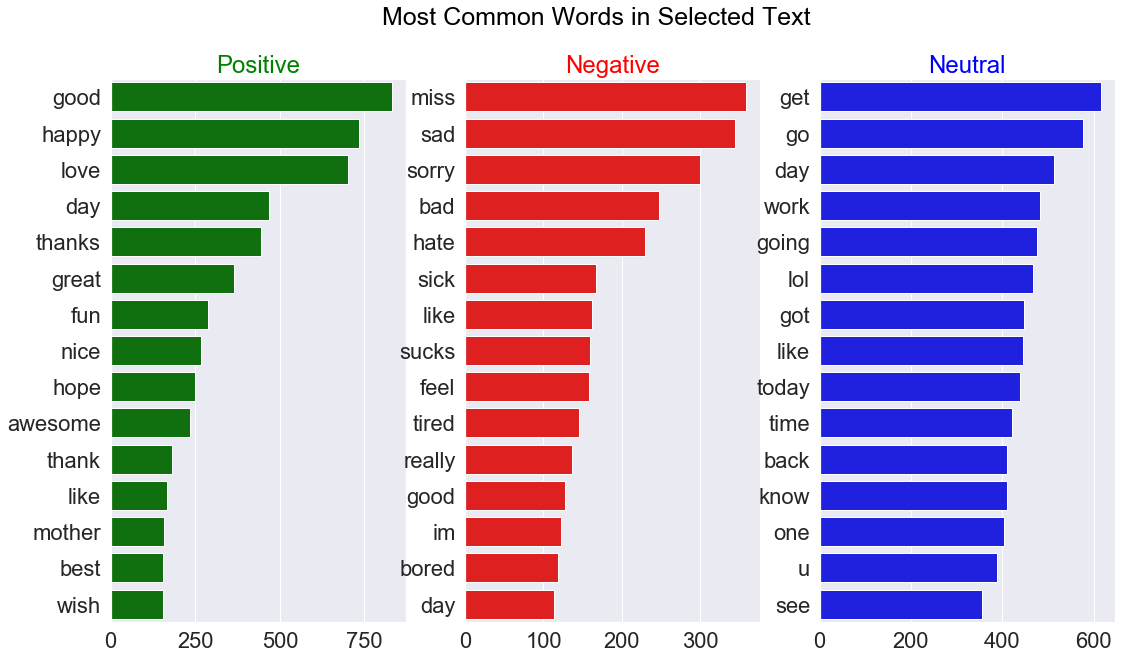

In [81]:
f, axes = plt.subplots(1,3,figsize=(18,10))
sns.set(font_scale =2)
sns.barplot(y=list(corpus_Tweetsentiment(tweet_train,'target','positive')[0])[:15], x= list(corpus_Tweetsentiment(tweet_train,'target','positive')[1])[:15],color="green",ax=axes[0]).set_title("Positive",color="green")
sns.barplot(y=list(corpus_Tweetsentiment(tweet_train,'target','negative')[0])[:15], x=list(corpus_Tweetsentiment(tweet_train,'target','negative')[1])[:15],color="red", ax=axes[1]).set_title("Negative",color="red")
sns.barplot(y=list(corpus_Tweetsentiment(tweet_train,'target','neutral')[0])[:15], x=list(corpus_Tweetsentiment(tweet_train,'target','neutral')[1])[:15],color="blue", ax=axes[2]).set_title("Neutral",color="blue")

plt.suptitle("Most Common Words in Selected Text" ,fontsize=25,color="black")
plt.show() 

Observation:

Positive produces words like good,happy,thanks which is quite expected
Negative produces words like miss,sad,sorry,bad which indicates negative emotions
Neutral produces words like get,going,work which is sort of common words
We could see "day" comes in all three sentiments.(These tweets might be indicating a event day.Hopefully we may come to know after competition)

In [65]:
TrainTest_data = pd.concat([tweet_train,tweet_test])
TrainTest_data['text']=TrainTest_data['text'].str.lower()
TrainTest_data.shape


(31014, 15)

In [67]:
tweet_train_word=TrainTest_data[:tweet_train.shape[0]]
tweet_test_word=TrainTest_data[tweet_test.shape[0]:]

In [64]:
#function for N-gram of (N)grams - Train Selected text
def N_grams_plot(corpus,ngram_range,n=None):
    """
    List the top n words in a vocabulary according to occurrence in a text corpus.
    """
    vec = CountVectorizer(stop_words = 'english',ngram_range=ngram_range).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    total_list=words_freq[:n]
    df=pd.DataFrame(total_list,columns=['text','count'])
    return df

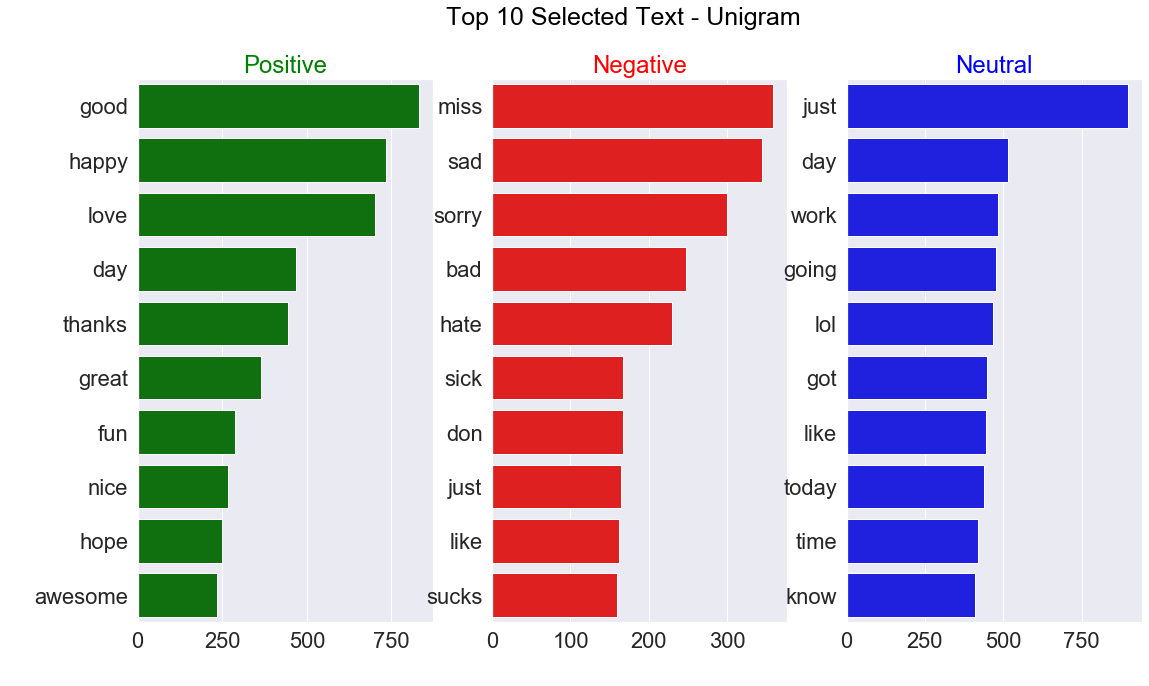

In [82]:
f, axes = plt.subplots(1,3,figsize=(18,10))
sns.set(font_scale =2)
sns.barplot(y=N_grams_plot(tweet_train_word.loc[tweet_train_word['sentiment']=='positive']['target'],(1,1),10)['text'],
            x= N_grams_plot(tweet_train_word.loc[tweet_train_word['sentiment']=='positive']['target'],(1,1),10)['count'],
            color="green",ax=axes[0]).set_title("Positive",color="green")
axes[0].set(ylabel=" ",xlabel=" ")
sns.barplot(y=N_grams_plot(tweet_train_word.loc[tweet_train_word['sentiment']=='negative']['target'],(1,1),10)['text'],
            x=N_grams_plot(tweet_train_word.loc[tweet_train_word['sentiment']=='negative']['target'],(1,1),10)['count'],
            color="red", ax=axes[1]).set_title("Negative",color="red")
axes[1].set(ylabel=" ",xlabel=" ")
sns.barplot(y=N_grams_plot(tweet_train_word.loc[tweet_train_word['sentiment']=='neutral']['target'],(1,1),10)['text'], 
            x=N_grams_plot(tweet_train_word.loc[tweet_train_word['sentiment']=='neutral']['target'],(1,1),10)['count'],
            color="blue", ax=axes[2]).set_title("Neutral",color="blue")
axes[2].set(ylabel=" ",xlabel=" ")
f.suptitle("Top 10 Selected Text - Unigram" ,fontsize=25,color="black")
f.show() 





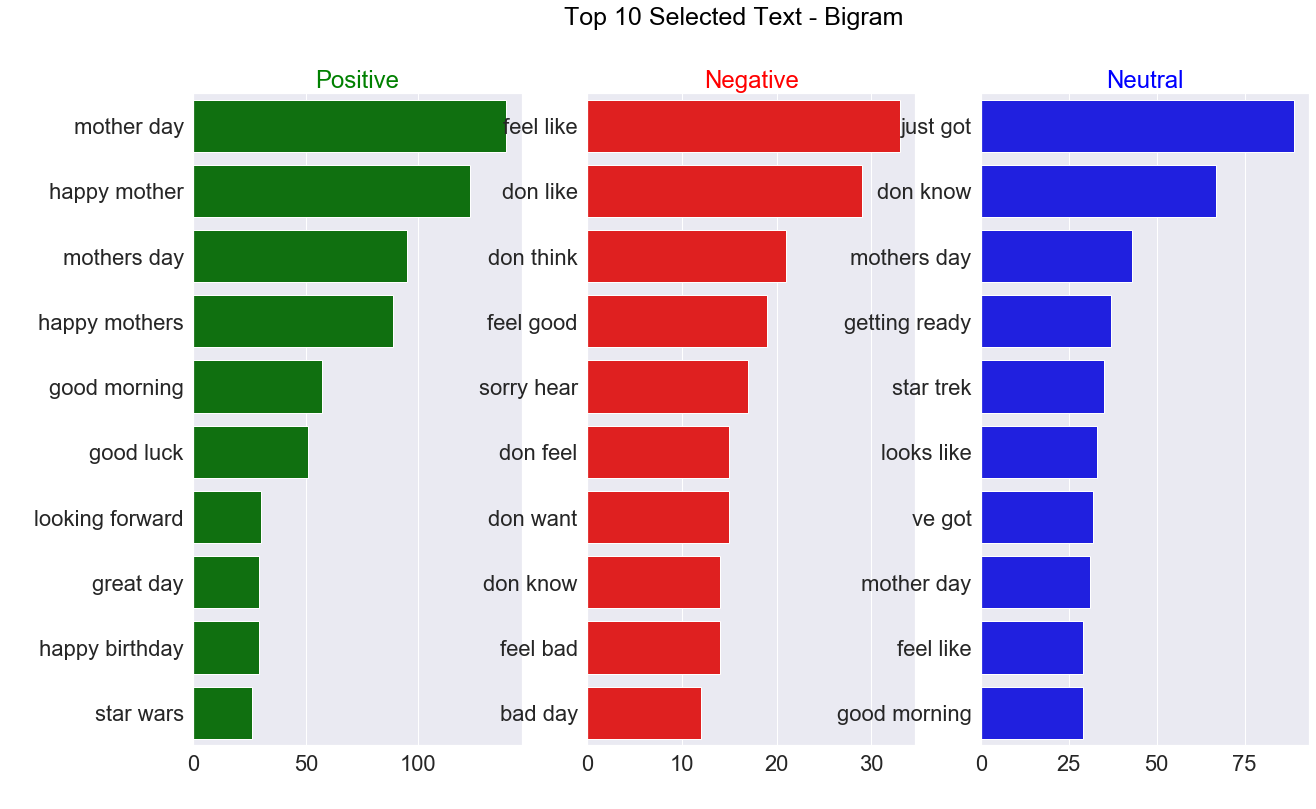

In [71]:
f, axes = plt.subplots(1,3,figsize=(20,12))
sns.set(font_scale =2)
sns.barplot(y=N_grams_plot(tweet_train_word.loc[tweet_train_word['sentiment']=='positive']['target'],(2,2),10)['text'],
            x= N_grams_plot(tweet_train_word.loc[tweet_train_word['sentiment']=='positive']['target'],(2,2),10)['count'],
            color="green",ax=axes[0]).set_title("Positive",color="green")
axes[0].set(ylabel=" ",xlabel=" ")
sns.barplot(y=N_grams_plot(tweet_train_word.loc[tweet_train_word['sentiment']=='negative']['target'],(2,2),10)['text'],
            x=N_grams_plot(tweet_train_word.loc[tweet_train_word['sentiment']=='negative']['target'],(2,2),10)['count'],
            color="red", ax=axes[1]).set_title("Negative",color="red")
axes[1].set(ylabel=" ",xlabel=" ")
sns.barplot(y=N_grams_plot(tweet_train_word.loc[tweet_train_word['sentiment']=='neutral']['target'],(2,2),10)['text'], 
            x=N_grams_plot(tweet_train_word.loc[tweet_train_word['sentiment']=='neutral']['target'],(2,2),10)['count'],
            color="blue", ax=axes[2]).set_title("Neutral",color="blue")
axes[2].set(ylabel=" ",xlabel=" ")
f.suptitle("Top 10 Selected Text - Bigram" ,fontsize=25,color="black")
f.show() 


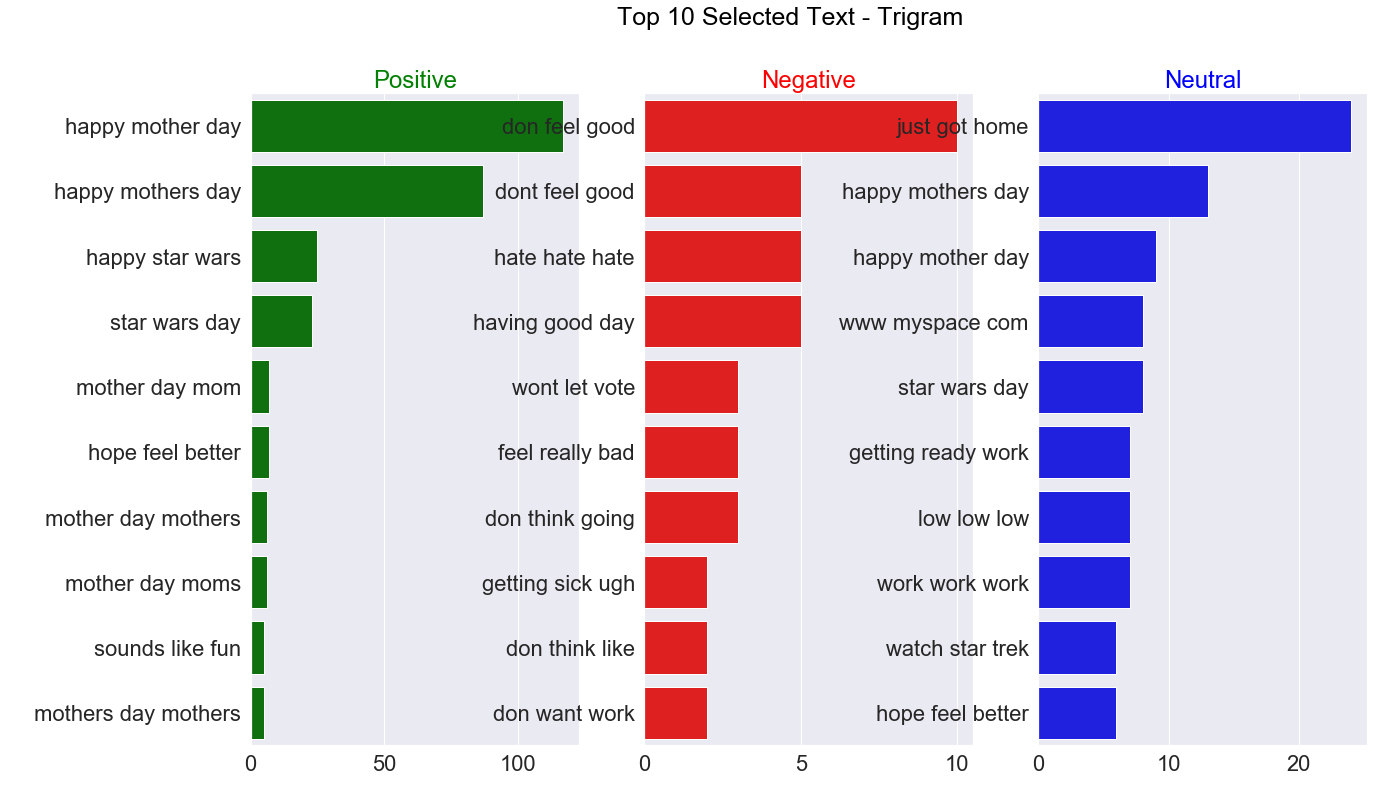

In [72]:
f, axes = plt.subplots(1,3,figsize=(20,12))
sns.set(font_scale =2)
sns.barplot(y=N_grams_plot(tweet_train_word.loc[tweet_train_word['sentiment']=='positive']['target'],(3,3),10)['text'],
            x= N_grams_plot(tweet_train_word.loc[tweet_train_word['sentiment']=='positive']['target'],(3,3),10)['count'],
            color="green",ax=axes[0]).set_title("Positive",color="green")
axes[0].set(ylabel=" ",xlabel=" ")
sns.barplot(y=N_grams_plot(tweet_train_word.loc[tweet_train_word['sentiment']=='negative']['target'],(3,3),10)['text'],
            x=N_grams_plot(tweet_train_word.loc[tweet_train_word['sentiment']=='negative']['target'],(3,3),10)['count'],
            color="red", ax=axes[1]).set_title("Negative",color="red")
axes[1].set(ylabel=" ",xlabel=" ")
sns.barplot(y=N_grams_plot(tweet_train_word.loc[tweet_train_word['sentiment']=='neutral']['target'],(3,3),10)['text'], 
            x=N_grams_plot(tweet_train_word.loc[tweet_train_word['sentiment']=='neutral']['target'],(3,3),10)['count'],
            color="blue", ax=axes[2]).set_title("Neutral",color="blue")
axes[2].set(ylabel=" ",xlabel=" ")
f.suptitle("Top 10 Selected Text - Trigram" ,fontsize=25,color="black")
f.show() 

Observation:

"Day" was always a part among all sentiment tweets and thus confirmed the event.Well,"Happy Mothers day".All these tweets were collected around May 2nd Week.
Positive bigrams and trigrams words are more biased towards mothers day.
Negative ngrams are displaying negative emotional words.
Neutral shows common words.Nothing much inference from this sentiment.

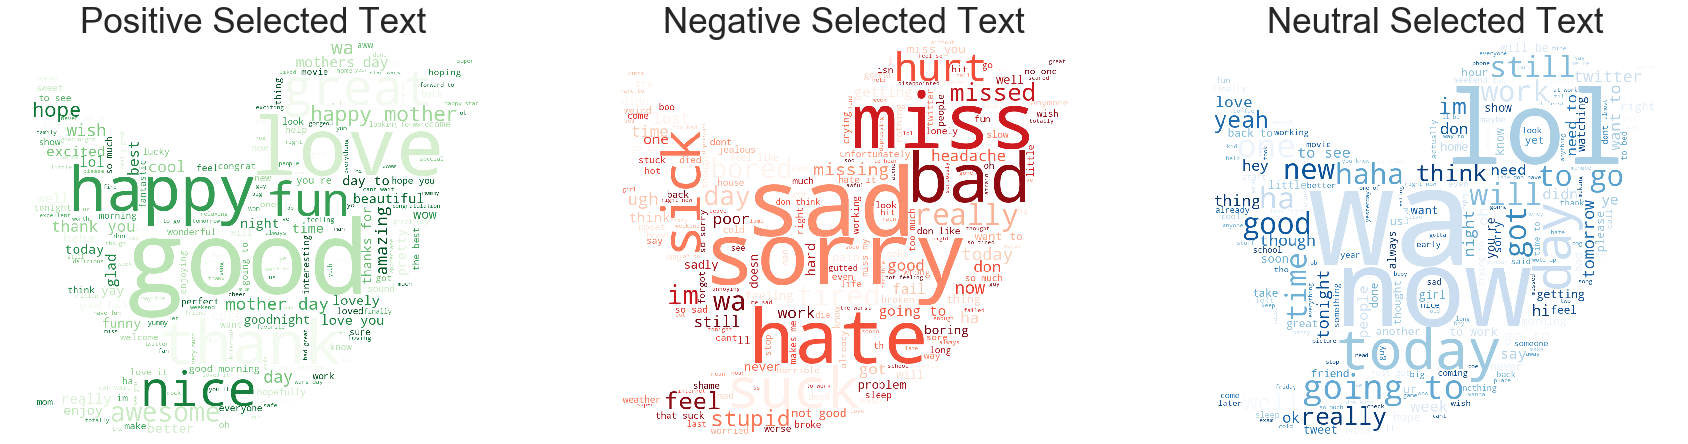

In [80]:
d = 'C:/Users/priya/Documents/Predictive Analytics/Project/'
bird = np.array(Image.open(d + 'twitterMask.png'))
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=[30, 15])
wordcloud1 = WordCloud( background_color='white',mask=bird,colormap="Greens",
                        width=600,
                        height=400).generate(" ".join(tweet_train_word.loc[tweet_train_word['sentiment']=="positive"]['target']))
ax1.imshow(wordcloud1)
ax1.axis('off')
ax1.set_title('Positive Selected Text',fontsize=35);

wordcloud2 = WordCloud( background_color='white',mask=bird,colormap="Reds",
                        width=600,
                        height=400).generate(" ".join(tweet_train_word.loc[tweet_train_word['sentiment']=="negative"]['target']))
ax2.imshow(wordcloud2)
ax2.axis('off')
ax2.set_title('Negative Selected Text',fontsize=35);

wordcloud3 = WordCloud( background_color='white',mask=bird,colormap="Blues",
                        width=600,
                        height=400).generate(" ".join(tweet_train_word.loc[tweet_train_word['sentiment']=="neutral"]['target']))
ax3.imshow(wordcloud3)
ax3.axis('off')
ax3.set_title('Neutral Selected Text',fontsize=35);


In [56]:
tweet_train['Num_words_text'] = tweet_train['text'].apply(lambda x:len(str(x).split())) #Number Of words in main Text in train set

In [57]:
tweet_train = tweet_train[tweet_train['Num_words_text']>=3]

In [58]:
tweet_train

,textID,text,selected_text,sentiment,Num_words_text
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,7
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,10
2,088c60f138,my boss is bullying me...,bullying me,negative,5
3,9642c003ef,what interview! leave me alone,leave me alone,negative,5
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,14
...,...,...,...,...,...
27476,4eac33d1c0,wish we could come see u on Denver husband l...,d lost,negative,16
27477,4f4c4fc327,I`ve wondered about rake to. The client has ...,", don`t force",negative,23
27478,f67aae2310,Yay good for both of you. Enjoy the break - y...,Yay good for both of you.,positive,22
27479,ed167662a5,But it was worth it ****.,But it was worth it ****.,positive,6


In [27]:
pip install -U spacy 

  Created wheel for wasabi: filename=wasabi-0.7.0-py3-none-any.whl size=20838 sha256=e07b599b1232ab4e4096f40ddfd11f9874911a3610973800b32505fc7da2c98f
  Stored in directory: c:\users\priya\appdata\local\pip\cache\wheels\68\38\40\b82a00fbe88220b7fd467c29a0018357066e14466151189e5a
Successfully built wasabi
Note: you may need to restart the kernel to use updated packages.


In [34]:
pip install tqdm

Note: you may need to restart the kernel to use updated packages.


In [35]:
from tqdm import tqdm
import os
import nltk
import spacy
import random
from spacy.util import compounding
from spacy.util import minibatch

import warnings
warnings.filterwarnings("ignore")

In [20]:
def save_model(output_dir, nlp, new_model_name):
    ''' This Function Saves model to 
    given output directory'''
    
    output_dir = f'../working/{output_dir}'
    if output_dir is not None:        
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        nlp.meta["name"] = new_model_name
        nlp.to_disk(output_dir)
        print("Saved model to", output_dir)

In [31]:
# pass model = nlp if you want to train on top of existing model 

def train(train_data, output_dir, n_iter=20, model=None):
    """Load the model, set up the pipeline and train the entity recognizer."""
    ""
    if model is not None:
        nlp = spacy.load(output_dir)  # load existing spaCy model
        print("Loaded model '%s'" % model)
    else:
        nlp = spacy.blank("en")  # create blank Language class
        print("Created blank 'en' model")
    
    # create the built-in pipeline components and add them to the pipeline
    # nlp.create_pipe works for built-ins that are registered with spaCy
    if "ner" not in nlp.pipe_names:
        ner = nlp.create_pipe("ner")
        nlp.add_pipe(ner, last=True)
    # otherwise, get it so we can add labels
    else:
        ner = nlp.get_pipe("ner")
    
    # add labels
    for _, annotations in train_data:
        for ent in annotations.get("entities"):
            ner.add_label(ent[2])

    # get names of other pipes to disable them during training
    other_pipes = [pipe for pipe in nlp.pipe_names if pipe != "ner"]
    with nlp.disable_pipes(*other_pipes):  # only train NER
        # sizes = compounding(1.0, 4.0, 1.001)
        # batch up the examples using spaCy's minibatch
        if model is None:
            nlp.begin_training()
        else:
            nlp.resume_training()

        for itn in tqdm(range(n_iter)):
            random.shuffle(train_data)
            batches = minibatch(train_data, size=compounding(4.0, 500.0, 1.001))    
            losses = {}
            for batch in batches:
                texts, annotations = zip(*batch)
                nlp.update(
                    texts,  # batch of texts
                    annotations,  # batch of annotations
                    drop=0.5,   # dropout - make it harder to memorise data
                    losses=losses, 
                )
            
            print("Losses", losses)
    save_model(output_dir, nlp, 'st_ner')

In [32]:
def get_model_out_path(sentiment):
    '''
    Returns Model output path
    '''
    model_out_path = None
    if sentiment == 'positive':
        model_out_path = 'models/model_pos'
    elif sentiment == 'negative':
        model_out_path = 'models/model_neg'
    return model_out_path

In [24]:
## creating data in spacy data input format

def get_training_data(sentiment):
    train_data = []
    for index, row in train_df.iterrows():
        if row.sentiment == sentiment:
            selected_text = row.selected_text
            text = row.text
            start = text.find(selected_text)
            end = start + len(selected_text)
            train_data.append((text, {"entities": [[start, end, 'selected_text']]}))
    return train_data

In [36]:
sentiment = 'positive'

train_data = get_training_data(sentiment)
model_path = get_model_out_path(sentiment)
# For DEmo Purposes I have taken 3 iterations you can train the model as you want
train(train_data, model_path, n_iter=3, model=None)

  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

Created blank 'en' model


 33%|████████████████████████████                                                        | 1/3 [01:00<02:00, 60.08s/it]

Losses {'ner': 33804.31204329392}


 67%|████████████████████████████████████████████████████████                            | 2/3 [02:03<01:01, 61.17s/it]

Losses {'ner': 31101.495509448298}


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [03:09<00:00, 63.05s/it]

Losses {'ner': 29600.68868503753}
Saved model to ../working/models/model_pos


In [37]:
sentiment = 'positive'

train_data = get_training_data(sentiment)
model_path = get_model_out_path(sentiment)

# for demo purpose i am just training the model for 2 iterations, feel free to experiment.
train(train_data, model_path, n_iter=3, model=None)

  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

Created blank 'en' model


 33%|████████████████████████████                                                        | 1/3 [01:01<02:03, 61.63s/it]

Losses {'ner': 33141.255620634256}


 67%|████████████████████████████████████████████████████████                            | 2/3 [02:06<01:02, 62.60s/it]

Losses {'ner': 31113.458676436858}


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [03:13<00:00, 64.34s/it]

Losses {'ner': 29382.508455485477}
Saved model to ../working/models/model_pos


In [38]:
sentiment = 'negative'

train_data = get_training_data(sentiment)
model_path = get_model_out_path(sentiment)

# for demo purpose i am just training the model for 2 iterations, feel free to experiment.
train(train_data, model_path, n_iter=3, model=None)

  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

Created blank 'en' model


 33%|████████████████████████████                                                        | 1/3 [00:58<01:57, 58.61s/it]

Losses {'ner': 31776.456860374543}


 67%|████████████████████████████████████████████████████████                            | 2/3 [01:59<00:59, 59.38s/it]

Losses {'ner': 28825.183855316645}


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [03:00<00:00, 60.06s/it]

Losses {'ner': 26935.827315625298}
Saved model to ../working/models/model_neg


In [39]:
sentiment = 'neutral'

train_data = get_training_data(sentiment)
model_path = get_model_out_path(sentiment)

# for demo purpose i am just training the model for 2 iterations, feel free to experiment.
train(train_data, model_path, n_iter=3, model=None)

  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

Created blank 'en' model


 33%|████████████████████████████                                                        | 1/3 [01:11<02:23, 71.90s/it]

Losses {'ner': 7154.231044413816}


 67%|████████████████████████████████████████████████████████                            | 2/3 [02:35<01:15, 75.55s/it]

Losses {'ner': 5328.988946265768}


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [04:05<00:00, 81.99s/it]

Losses {'ner': 5037.338790519025}
Saved model to ../working/None


In [62]:
def predict_entities(text, model):
    doc = model(text)
    ent_array = []
    for ent in doc.ents:
        start = text.find(ent.text)
        end = start + len(ent.text)
        new_int = [start, end, ent.label_]
        if new_int not in ent_array:
            ent_array.append([start, end, ent.label_])
    selected_text = text[ent_array[0][0]: ent_array[0][1]] if len(ent_array) > 0 else text
    return selected_text

In [63]:
selected_texts = []
MODELS_BASE_PATH = 'C:/Users/priya/Documents/Predictive Analytics/working/models/'

if MODELS_BASE_PATH is not None:
    print("Loading Models  from ", MODELS_BASE_PATH)
    model_pos = spacy.load(MODELS_BASE_PATH + 'model_pos')
    model_neg = spacy.load(MODELS_BASE_PATH + 'model_neg')
    model_neu = spacy.load(MODELS_BASE_PATH + 'model_neu')
        
    for index, row in tweet_test.iterrows():
        text = row.text
        output_str = ""
        if len(text.split()) <= 2:
            selected_texts.append(text)
        elif row.sentiment == 'neutral':
            selected_texts.append(predict_entities(text, model_neu))
        elif row.sentiment == 'positive':
            selected_texts.append(predict_entities(text, model_pos))
        else:
            selected_texts.append(predict_entities(text, model_neg))
        
tweet_test['selected_text'] = selected_texts

Loading Models  from  C:/Users/priya/Documents/Predictive Analytics/working/models/


In [65]:
tweet_submission['selected_text'] = tweet_test['selected_text']
tweet_submission.to_csv("submission.csv", index=False)
display(tweet_submission.head(10))

,textID,selected_text
0,f87dea47db,Last session of the day http://twitpic.com/67ezh
1,96d74cb729,Good
2,eee518ae67,shame!
3,01082688c6,happy bday!
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!
5,726e501993,that`s great!! weee!! visitors!
6,261932614e,I THINK EVERYONE HATES ME ON HERE lol
7,afa11da83f,"soooooo wish i could, but im in school and my..."
8,e64208b4ef,and within a short time of the last clue all o...
9,37bcad24ca,What did you get? My day is alright.. haven`t...
